In [1]:
# Import modules
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest as ztest
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# Import data
data = pd.read_csv('./Data.csv', header=0)
SP500 = pd.read_csv('./SP500.csv', header=0)
CapitalIQ = pd.read_csv('./CapitalIQ.csv', header=0)

# Convert date to YYYYmm format and set as Index
data = pd.read_csv('./Data.csv', header=0)
data['date'] = pd.to_datetime(data['date'].astype(str))
data['date'] = data['date'].dt.strftime('%Y%m')
data.set_index('date',inplace=True)

SP500['Date'] = pd.to_datetime(SP500['Date'], format='%Y%m')
SP500['Date'] = SP500['Date'].dt.strftime('%Y%m')
SP500.set_index('Date',inplace=True)

CapitalIQ['Date'] = pd.to_datetime(CapitalIQ['Date'], format='%Y%m%d', errors='ignore').dt.strftime('%Y%m')
CapitalIQ.set_index('Date',inplace=True)

# Append SP500 to data
data['ret_sp500'] = SP500['ret_sp500']
data['rf'] = SP500['rf']

# Convert percentage to decimal
data['trt1m'] = data['trt1m']/100

# Subset data using period 197001-201912
data = data.sort_values(by='date').loc['197001':'201912']

In [ ]:
data.head()

In [3]:
data

,gvkey,iid,tic,cusip,ajexm,prccm,prchm,prclm,trfm,trt1m,...,NUMDOWN,FY_1,LTG,actual,surpmean,surpstdev,lpermno,sp500,ret_sp500,rf
date,,,,,,,,,,,,,,,,,,,,,
197001,5776,1,GHC.1,363233107,21.5989,32.4999,34.2499,30.9999,1.0000,0.048388,...,NaN,NaN,NaN,NaN,NaN,NaN,48653,0,-0.075398,0.0060
197001,4103,1,DQE,266233105,1.5000,23.3750,25.2500,22.5000,1.4547,-0.015789,...,NaN,NaN,NaN,NaN,NaN,NaN,25072,1,-0.075398,0.0060
197001,3022,1,C.3,171196108,4.5000,28.0000,35.7500,26.7500,1.2755,-0.185455,...,NaN,NaN,NaN,NaN,NaN,NaN,11260,1,-0.075398,0.0060
197001,3125,1,CLU.2,189486103,1.0000,24.5000,31.3750,24.0000,1.2968,-0.206478,...,NaN,NaN,NaN,NaN,NaN,NaN,11295,1,-0.075398,0.0060
197001,5870,1,IDA,451107106,2.0000,28.6250,31.0000,28.1250,1.3722,-0.071200,...,NaN,NaN,NaN,NaN,NaN,NaN,21928,1,-0.075398,0.0060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,1920,1,AVP,054303102,1.0000,5.6400,5.8200,4.5200,6.6733,0.232254,...,0.0,0.06,134.80,NaN,NaN,NaN,40416,0,0.029788,0.0014
201912,4605,1,FRT,313747206,1.0000,128.7300,133.0200,126.6900,18.9463,-0.017339,...,0.0,0.79,NaN,NaN,NaN,NaN,58413,1,0.029788,0.0014
201912,158742,1,MKTX,57060D108,1.0000,379.1100,406.3500,365.6900,1.1575,-0.061191,...,3.0,1.34,14.75,NaN,NaN,NaN,90454,1,0.029788,0.0014


## Factors Defination

In [3]:
# 1. Price Momentum
# Defination: 1 month price High - Low
def HL1M(prchm, prccm, prclm):
    return ((prchm-prccm)/(prccm-prclm)).replace([np.inf, -np.inf], np.nan)


# 3. Long-Term Momentum
# Defination: the simple average of monthly stock returns from the past 12 month to the past 2 month
def MOM(trt1m):
    return 1/11 * (trt1m.rolling(13).sum() - trt1m.rolling(2).sum())


# 4. Valuation: Book to Price
def BP(ceqq, cshoq, prccm):
    return (ceqq/(cshoq*prccm)).replace([np.inf, -np.inf], np.nan)


# 5. CAPM Beta
# Defination: the coefficient of regressing stock excess returns on market excess returns
def CAPM_Beta(trt1m, rf, ret_sp500):
    y = trt1m - rf
    x = ret_sp500 - rf
    beta = y.rolling(48).cov(x)/x.rolling(48).var()
    return beta.replace([np.inf, -np.inf], np.nan)


# 6. Size: Log Market Cap
def LogMCap(cshom, prccm):
    return (np.log(cshom*prccm)).replace([np.inf, -np.inf], np.nan)


# 7. Volatility: 12-Month realized price volatility
def AnnVol(prccm):
    r =  ((np.log(prccm/prccm.shift(periods=1)))**2).rolling(12)
    return np.sqrt(12) * np.sqrt(1/11 * r.sum())

In [4]:
# Map x to a dataframe with index as date and column as gvkey
def create_df(x, data):
    df = data[[x, 'gvkey']].pivot(columns='gvkey')
    df.columns = df.columns.droplevel(0)
    return df

## 1. Price Momentum

In [5]:
prchm = create_df('prchm', data)
prccm = create_df('prccm', data)
prclm = create_df('prclm', data)
df1 = HL1M(prchm, prccm, prclm)

In [6]:
df1

gvkey,1010,1013,1040,1043,1045,1062,1070,1075,1078,1098,...,189491,198058,199356,260774,260778,265975,266101,294524,316056,326688
date,,,,,,,,,,,,,,,,,,,,,
197001,14.000000,NaN,15.000000,NaN,NaN,2.411765,5.500000,11.500000,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,1.000000,7.666667,NaN,NaN,NaN
197002,0.066667,NaN,0.111111,5.538462,0.028169,0.000000,1.000000,0.043478,0.333333,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,0.037037,NaN,NaN,NaN
197003,0.571429,NaN,0.090909,0.354839,2.181818,0.081967,0.428571,0.818182,0.833333,10.0,...,NaN,NaN,NaN,NaN,NaN,1.181818,NaN,NaN,NaN,NaN
197004,2.000000,NaN,1.461538,3.714286,3.555556,1.217391,NaN,23.000000,2.350000,1.0,...,NaN,NaN,NaN,NaN,NaN,9.500000,NaN,NaN,NaN,NaN
197005,2.304348,NaN,0.285714,2.727273,0.317073,15.250000,1.583333,2.222222,1.333333,11.0,...,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,2.045673,0.271084,NaN,0.099332,0.691919,NaN,...,1.377301,9.780105,3.158915,1.284404,2.345382,NaN,NaN,0.816990,2.514970,4.122449
201909,NaN,NaN,NaN,NaN,3.303922,17.100000,NaN,0.256367,1.041509,NaN,...,0.153430,0.066961,2.181892,1.717033,17.200000,NaN,NaN,0.067992,0.117581,0.376518
201910,NaN,NaN,NaN,NaN,0.290090,0.032862,NaN,1.650485,0.227451,NaN,...,2.349476,0.639535,0.103343,0.139875,0.105750,NaN,NaN,0.301685,0.062925,0.094527


## 2. Expected LTG

In [7]:
df2 = create_df('LTG', data)

In [8]:
df2

gvkey,1010,1013,1040,1043,1045,1062,1070,1075,1078,1098,...,189491,198058,199356,260774,260778,265975,266101,294524,316056,326688
date,,,,,,,,,,,,,,,,,,,,,
197001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,15.49,NaN,NaN,5.05,11.81,NaN,...,13.42,5.43,14.37,NaN,20.23,NaN,NaN,6.33,8.26,7.30
201909,NaN,NaN,NaN,NaN,15.49,NaN,NaN,5.05,11.81,NaN,...,13.42,5.43,14.37,NaN,20.23,NaN,NaN,6.33,7.89,7.30
201910,NaN,NaN,NaN,NaN,12.87,NaN,NaN,5.05,11.61,NaN,...,12.01,5.43,14.27,9.6,20.23,NaN,NaN,3.63,7.48,4.40


## 3. Long-Term Momentum

In [9]:
trt1m = create_df('trt1m', data)
df3 = MOM(trt1m)

In [10]:
df3

gvkey,1010,1013,1040,1043,1045,1062,1070,1075,1078,1098,...,189491,198058,199356,260774,260778,265975,266101,294524,316056,326688
date,,,,,,,,,,,,,,,,,,,,,
197001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,-0.007191,0.016333,NaN,0.017370,0.025413,NaN,...,0.013627,-0.048916,-0.013606,0.006841,0.010234,NaN,NaN,-0.014286,0.031642,-0.002666
201909,NaN,NaN,NaN,NaN,-0.015436,0.029205,NaN,0.017435,0.027199,NaN,...,0.010508,-0.054554,-0.012040,0.011678,-0.001020,NaN,NaN,-0.018494,0.019545,-0.004894
201910,NaN,NaN,NaN,NaN,-0.029561,0.039778,NaN,0.020782,0.016473,NaN,...,0.001871,-0.072997,-0.019301,0.019182,-0.011629,NaN,NaN,-0.017876,0.009451,-0.018496


## 4. Valuation:  Book to Price

In [11]:
ceqq = create_df('ceqq', data)
cshoq = create_df('cshoq', data)
prccm = create_df('prccm', data)
df4 = BP(ceqq, cshoq, prccm)

In [12]:
df4

gvkey,1010,1013,1040,1043,1045,1062,1070,1075,1078,1098,...,189491,198058,199356,260774,260778,265975,266101,294524,316056,326688
date,,,,,,,,,,,,,,,,,,,,,
197001,0.736925,NaN,0.571365,NaN,0.867679,1.124589,1.370687,NaN,0.237035,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197002,0.710128,NaN,0.479539,NaN,0.689786,1.014252,1.433950,NaN,0.228807,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197003,0.693907,NaN,0.468387,NaN,0.766786,0.772810,1.380841,NaN,0.236226,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197004,NaN,NaN,NaN,NaN,NaN,0.830519,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197005,NaN,NaN,NaN,NaN,NaN,0.849834,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,-0.001878,0.884131,NaN,0.488908,0.210127,NaN,...,0.209749,0.580499,0.297687,0.304132,0.337944,NaN,NaN,0.374068,0.073417,0.740693
201909,NaN,NaN,NaN,NaN,-0.001832,1.337446,NaN,0.480044,0.214271,NaN,...,0.201819,0.461808,0.292377,0.299887,0.353031,NaN,NaN,0.323521,0.068190,0.680873
201910,NaN,NaN,NaN,NaN,0.012151,1.262852,NaN,0.525124,0.215182,NaN,...,0.208951,0.510482,0.292712,0.306559,0.325415,NaN,NaN,0.263754,0.063462,0.657976


## 5. CAPM Beta

In [13]:
trt1m_new = create_df('trt1m', data)
rf = create_df('rf', data)
ret_sp500 = create_df('ret_sp500', data)
df5 = CAPM_Beta(trt1m_new, rf, ret_sp500)

In [14]:
df5

gvkey,1010,1013,1040,1043,1045,1062,1070,1075,1078,1098,...,189491,198058,199356,260774,260778,265975,266101,294524,316056,326688
date,,,,,,,,,,,,,,,,,,,,,
197001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,1.904088,-0.084650,NaN,0.077473,1.115682,NaN,...,1.197894,0.946944,1.242959,1.714629,0.906599,NaN,NaN,1.482058,1.196858,NaN
201909,NaN,NaN,NaN,NaN,1.944416,-0.123748,NaN,0.118950,1.056112,NaN,...,1.219021,0.979692,1.214073,1.740962,0.871622,NaN,NaN,1.514157,1.202285,NaN
201910,NaN,NaN,NaN,NaN,1.892619,-0.121104,NaN,0.138159,1.015088,NaN,...,1.206659,1.189417,0.874881,1.700749,0.980222,NaN,NaN,1.513492,1.180759,NaN


## 6. Size: Log Market Cap

In [15]:
cshom = create_df('cshom', data)
df6 = LogMCap(cshom, prccm)

In [16]:
df6

gvkey,1010,1013,1040,1043,1045,1062,1070,1075,1078,1098,...,189491,198058,199356,260774,260778,265975,266101,294524,316056,326688
date,,,,,,,,,,,,,,,,,,,,,
197001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,23.184143,19.362861,NaN,23.093855,25.739183,NaN,...,23.347356,22.109224,22.293076,23.590044,23.334913,NaN,NaN,23.979103,22.919302,21.954732
201909,NaN,NaN,NaN,NaN,23.208919,19.261669,NaN,23.112152,25.719655,NaN,...,23.385894,22.337962,22.311076,23.604102,23.291238,NaN,NaN,24.124279,22.993165,22.038943
201910,NaN,NaN,NaN,NaN,23.301057,19.319059,NaN,23.081291,25.718937,NaN,...,23.348400,22.272860,22.354583,23.614237,23.426457,NaN,NaN,24.126846,23.101152,22.084396


## 7. Volatility: 12M Realized Price Volatility

In [17]:
df7 = AnnVol(prccm)

In [18]:
df7

gvkey,1010,1013,1040,1043,1045,1062,1070,1075,1078,1098,...,189491,198058,199356,260774,260778,265975,266101,294524,316056,326688
date,,,,,,,,,,,,,,,,,,,,,
197001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,0.507911,0.252885,NaN,0.144339,0.199462,NaN,...,0.338996,0.601946,0.436009,0.316384,0.304470,NaN,NaN,0.341846,0.278277,0.376084
201909,NaN,NaN,NaN,NaN,0.508107,0.273958,NaN,0.145359,0.175357,NaN,...,0.337220,0.644830,0.431659,0.298465,0.301945,NaN,NaN,0.360424,0.286078,0.384628
201910,NaN,NaN,NaN,NaN,0.491612,0.279526,NaN,0.143492,0.162905,NaN,...,0.269922,0.609064,0.433504,0.283349,0.294356,NaN,NaN,0.330225,0.304070,0.371261


## Summary: 7 factors

In [19]:
col_names = ['HL1M', 'LTGC', 'MOM', 'BP', 'Beta', 'LogMktCap', 'AnnVol12M']
factors = [df1,df2,df3,df4,df5,df6,df7]

In [20]:
# Select sp500 firms into a list: this list includes the companies that had ever counted as SP500
sp500_ind = create_df('sp500', data)
sp500_ind.replace(0, np.nan, inplace=True)
factors = [dfn*sp500_ind for dfn in factors]     
SP500Firms = sp500_ind.dropna(axis='columns', how ='all').columns.tolist()

In [21]:
# combine data of sp500 firms
total_frame = pd.concat(factors, keys=col_names)
total_frame = total_frame[total_frame.columns.intersection(SP500Firms)]
total_frame

gvkey                1010    1013       1040      1043      1045       1062    \
          date                                                                  
HL1M      197001  14.000000     NaN  15.000000       NaN       NaN   2.411765   
          197002   0.066667     NaN   0.111111  5.538462  0.028169   0.000000   
          197003   0.571429     NaN   0.090909  0.354839  2.181818   0.081967   
          197004   2.000000     NaN   1.461538  3.714286  3.555556   1.217391   
          197005   2.304348     NaN   0.285714  2.727273  0.317073  15.250000   
...                     ...     ...        ...       ...       ...        ...   
AnnVol12M 201908        NaN     NaN        NaN       NaN       NaN        NaN   
          201909        NaN     NaN        NaN       NaN       NaN        NaN   
          201910        NaN     NaN        NaN       NaN       NaN        NaN   
          201911        NaN     NaN        NaN       NaN       NaN        NaN   
          201912        NaN     NaN        NaN       NaN       NaN        NaN   

gvkey               1075      1078    1098       1133    ...    188255  \
          date                                           ...             
HL1M      197001       NaN       NaN    10.0  25.000000  ...       NaN   
          197002       NaN  0.333333     1.8   0.888889  ...       NaN   
          197003       NaN  0.833333    10.0   9.000000  ...       NaN   
          197004       NaN  2.350000     1.0   7.666667  ...       NaN   
          197005       NaN  1.333333    11.0   0.368421  ...       NaN   
...                    ...       ...     ...        ...  ...       ...   
AnnVol12M 201908  0.144339  0.199462     NaN        NaN  ...  0.382124   
          201909  0.145359  0.175357     NaN        NaN  ...  0.388640   
          201910  0.143492  0.162905     NaN        NaN  ...  0.366389   
          201911  0.138186  0.146552     NaN        NaN  ...  0.369608   
          201912  0.132332  0.145489     NaN        NaN  ...  0.340085   

gvkey               189491    198058    199356    260774    260778    265975  \
          date                                                                 
HL1M      197001       NaN       NaN       NaN       NaN       NaN  1.000000   
          197002       NaN       NaN       NaN       NaN       NaN       NaN   
          197003       NaN       NaN       NaN       NaN       NaN  1.181818   
          197004       NaN       NaN       NaN       NaN       NaN  9.500000   
          197005       NaN       NaN       NaN       NaN       NaN  3.000000   
...                    ...       ...       ...       ...       ...       ...   
AnnVol12M 201908  0.338996  0.601946  0.436009  0.316384  0.304470       NaN   
          201909  0.337220  0.644830  0.431659  0.298465  0.301945       NaN   
          201910  0.269922  0.609064  0.433504  0.283349  0.294356       NaN   
          201911  0.245991  0.587198  0.526487  0.278329  0.295199       NaN   
          201912  0.228102  0.568573       NaN  0.273673  0.285350       NaN   

gvkey               266101    294524    316056  
          date                                  
HL1M      197001  7.666667       NaN       NaN  
          197002  0.037037       NaN       NaN  
          197003       NaN       NaN       NaN  
          197004       NaN       NaN       NaN  
          197005       NaN       NaN       NaN  
...                    ...       ...       ...  
AnnVol12M 201908       NaN  0.341846  0.278277  
          201909       NaN  0.360424  0.286078  
          201910       NaN  0.330225  0.304070  
          201911       NaN  0.328590  0.298222  
          201912       NaN  0.306551  0.263373  

[4200 rows x 1517 columns]

In [22]:
# export to excel
writer = pd.ExcelWriter('Factor_SP500.xlsx', engine='xlsxwriter')
for i in col_names:
    df = total_frame.loc[i].loc["198701":"201912",].dropna(axis='columns', how ='all')
    df.to_excel(writer, sheet_name=i)
writer.save()

## Sort stocks into quintiles by factors

In [23]:
# this Function calculates the spread of the portfolio selected according to each factor
def Qspread(df, data, order=True):
    ## order = True for ascending; order = False for descending
    
    Q_spread = [] # the difference of returns between the top and bottom portfolio
    long_leg = [] # first quintile portfolio average return
    short_leg = [] # fifth quintile portfolio average return
    my_date = [] # a list of each month in the sample period
    top_prev = [] # last month long leg portfolio
    bottom_prev = [] # last month short leg portfolio
    turnover = [] # turnover rate of each month
    
    # Portfolio seleciton for each month using factor as an indicator
    for i in np.arange(0,len(df.columns)-1):
        column = df.columns[i]
        next_column = df.columns[i+1]
        
        # Construct first and fifth quintile portfolio
        new_df = df.sort_values(column, ascending=order)
        new_col = new_df.dropna(subset=[column])[column]
        bin_size = int(len(new_col)/5)
        top = new_col[:bin_size-1].index.tolist()
        bottom = new_col[-bin_size+1:].index.tolist()  
        
        # Calculate Average return of long top and short bottom portfolio
        # After portfolio selection at time t, use the following return at t+1 to capture the portfolio performance
        new_data = data.loc[next_column]
        top_return = new_data.loc[new_data['gvkey'].isin(top)]['trt1m'].mean()
        bottom_return = new_data.loc[new_data['gvkey'].isin(bottom)]['trt1m'].mean()
        diff = top_return - bottom_return
        
        # Store values
        Q_spread.append(diff)
        long_leg.append(top_return)
        short_leg.append(bottom_return)
        my_date.append(next_column)
        
        # Calculate turnover rate: difference in firms comparing time t and time t+1 / total firms at time t
        if len(top_prev) != 0:
            turnover_num = len(top) + len(top_prev) - 2*len(set(top).intersection(top_prev)) + len(bottom) + len(bottom_prev) - 2*len(set(bottom).intersection(bottom_prev))          
            turnover.append(turnover_num / (len(top_prev) + len(bottom_prev)))
      
        # Reset previous month portfolio structure
        top_prev = top
        bottom_prev = bottom
        
        
    return pd.DataFrame(Q_spread,my_date), pd.DataFrame(long_leg, my_date), pd.DataFrame(short_leg,my_date), np.mean(turnover)


In [24]:
# Subset data with data, gvkey and trt1m values
filtered_data = data.loc[:,['gvkey','trt1m']]
filtered_data = filtered_data.sort_values(by='date')

In [25]:
# Transpose date and gvkey for each factor
transpose_fcn = lambda x: x.transpose()
factors_transpose = [transpose_fcn(total_frame.loc[i]) for i in col_names]
total_frame_transpose = pd.concat(factors_transpose, keys=col_names)
total_frame_transpose

date              197001    197002    197003    197004    197005     197006  \
          gvkey                                                               
HL1M      1010      14.0  0.066667  0.571429  2.000000  2.304348        NaN   
          1013       NaN       NaN       NaN       NaN       NaN        NaN   
          1040      15.0  0.111111  0.090909  1.461538  0.285714   0.473684   
          1043       NaN  5.538462  0.354839  3.714286  2.727273        NaN   
          1045       NaN  0.028169  2.181818  3.555556  0.317073  28.500000   
...                  ...       ...       ...       ...       ...        ...   
AnnVol12M 260778     NaN       NaN       NaN       NaN       NaN        NaN   
          265975     NaN       NaN       NaN       NaN       NaN        NaN   
          266101     NaN       NaN       NaN       NaN       NaN        NaN   
          294524     NaN       NaN       NaN       NaN       NaN        NaN   
          316056     NaN       NaN       NaN       NaN       NaN        NaN   

date                197007    197008    197009    197010  ...    201903  \
          gvkey                                           ...             
HL1M      1010    1.400000  0.086957  0.058824  5.500000  ...       NaN   
          1013         NaN       NaN       NaN       NaN  ...       NaN   
          1040    0.125000  0.000000  0.142857  1.666667  ...       NaN   
          1043    0.276596  0.225806  3.153846  8.000000  ...       NaN   
          1045    0.193548  0.062500  0.285714  5.666667  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
AnnVol12M 260778       NaN       NaN       NaN       NaN  ...  0.356551   
          265975       NaN       NaN       NaN       NaN  ...       NaN   
          266101       NaN       NaN       NaN       NaN  ...       NaN   
          294524       NaN       NaN       NaN       NaN  ...  0.234231   
          316056       NaN       NaN       NaN       NaN  ...  0.241375   

date                201904    201905    201906    201907    201908    201909  \
          gvkey                                                                
HL1M      1010         NaN       NaN       NaN       NaN       NaN       NaN   
          1013         NaN       NaN       NaN       NaN       NaN       NaN   
          1040         NaN       NaN       NaN       NaN       NaN       NaN   
          1043         NaN       NaN       NaN       NaN       NaN       NaN   
          1045         NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
AnnVol12M 260778  0.354278  0.351911  0.335976  0.324832  0.304470  0.301945   
          265975       NaN       NaN       NaN       NaN       NaN       NaN   
          266101       NaN       NaN       NaN       NaN       NaN       NaN   
          294524  0.239575  0.293436  0.331178  0.332417  0.341846  0.360424   
          316056  0.236987  0.237902  0.273757  0.276773  0.278277  0.286078   

date                201910    201911    201912  
          gvkey                                 
HL1M      1010         NaN       NaN       NaN  
          1013         NaN       NaN       NaN  
          1040         NaN       NaN       NaN  
          1043         NaN       NaN       NaN  
          1045         NaN       NaN       NaN  
...                    ...       ...       ...  
AnnVol12M 260778  0.294356  0.295199  0.285350  
          265975       NaN       NaN       NaN  
          266101       NaN       NaN       NaN  
          294524  0.330225  0.328590  0.306551  
          316056  0.304070  0.298222  0.263373  

[10619 rows x 600 columns]

In [26]:
# Calculate Qspread, long/short portfolio returns and average turnover rate of each factor
order_list = [False, False, False, False, False, True, False]
Qspread_list = []
LongLeg_list = []
ShortLeg_list = []
AvgTurnover_list = []

for i in np.arange(0,len(col_names)):
    Qsp, Long, Short, AvgTurnover = Qspread(total_frame_transpose.loc[col_names[i]], filtered_data, order_list[i])
    Qspread_list.append(Qsp)
    LongLeg_list.append(Long)
    ShortLeg_list.append(Short)
    AvgTurnover_list.append(AvgTurnover)

In [27]:
# Qspread dataframe including 7 factors
Qspread_df = pd.concat(Qspread_list, axis=1)
Qspread_df.columns = col_names
Qspread_df

,HL1M,LTGC,MOM,BP,Beta,LogMktCap,AnnVol12M
197002,0.042163,NaN,NaN,0.018623,NaN,NaN,NaN
197003,0.011495,NaN,NaN,0.019825,NaN,NaN,NaN
197004,0.000168,NaN,NaN,-0.011393,NaN,NaN,NaN
197005,-0.008256,NaN,NaN,-0.003419,NaN,NaN,NaN
197006,0.034854,NaN,NaN,0.022544,NaN,NaN,NaN
...,...,...,...,...,...,...,...
201908,0.017973,0.001148,0.109490,-0.063077,-0.109705,-0.078959,-0.111565
201909,0.052526,-0.054832,-0.072601,0.064044,0.049268,0.071695,0.045185
201910,0.009305,0.011147,-0.022150,-0.022167,0.032099,-0.013291,0.025453
201911,-0.014775,-0.008574,-0.035206,-0.002526,0.054953,-0.007302,0.033213


In [28]:
# Construct long and short portfolio returns dataframe including 7 factors
LongLeg_df = pd.concat(LongLeg_list, axis=1)
LongLeg_df.columns = col_names
ShortLeg_df = pd.concat(ShortLeg_list, axis=1)
ShortLeg_df.columns = col_names

# Question 1

<AxesSubplot:xlabel='date'>

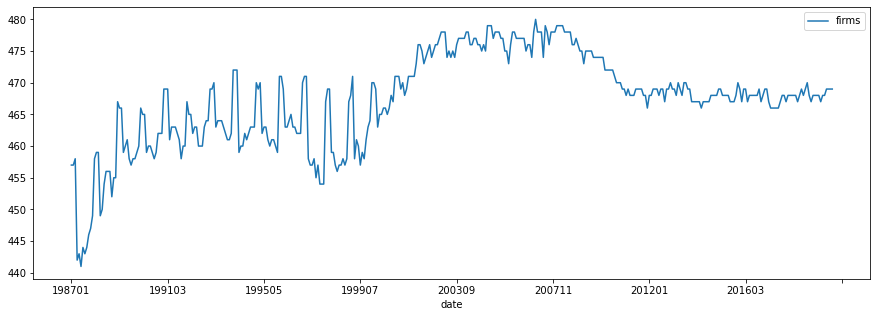

In [29]:
# Plot the time series of the number of firms
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,5]
subset = total_frame.loc['BP'].loc["198701":"201912"]
x = subset.index.tolist()
y = [subset.iloc[i].count() for i in np.arange(0,len(subset))]
firms_df = pd.DataFrame({'date': x, 'firms': y})
firms_df.plot('date', 'firms')

<AxesSubplot:>

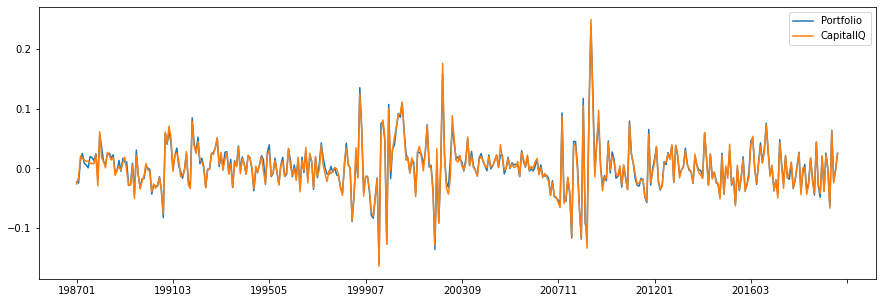

In [30]:
# Plot the time series of portfolio BP Qspread and CapitalIQ benchmark
plt.rcParams['figure.figsize'] = [15,5]
portfolio_BP = Qspread_df['BP'].loc["198701":"201912"]
CapitalIQ_BP = CapitalIQ['BP']
pd.concat([portfolio_BP, CapitalIQ_BP], axis=1,keys=['Portfolio', 'CapitalIQ']).plot()

<AxesSubplot:>

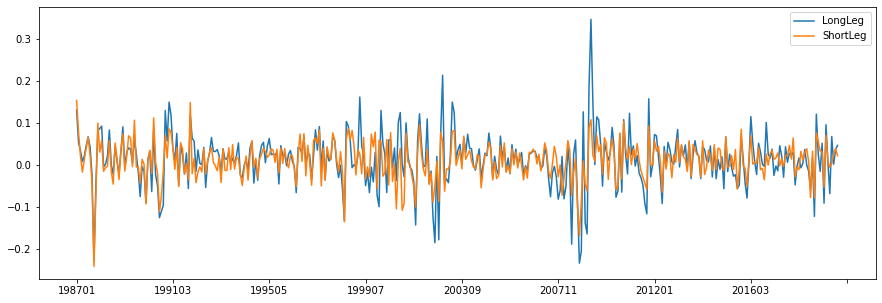

In [31]:
# Plot the long-leg and short-leg of the strategy
plt.rcParams['figure.figsize'] = [15,5]
Long_BP = LongLeg_df['BP'].loc["198701":"201912"]
Short_BP = ShortLeg_df['BP'].loc["198701":"201912"]
pd.concat([Long_BP, Short_BP], axis=1, keys=['LongLeg', 'ShortLeg']).plot()

<AxesSubplot:>

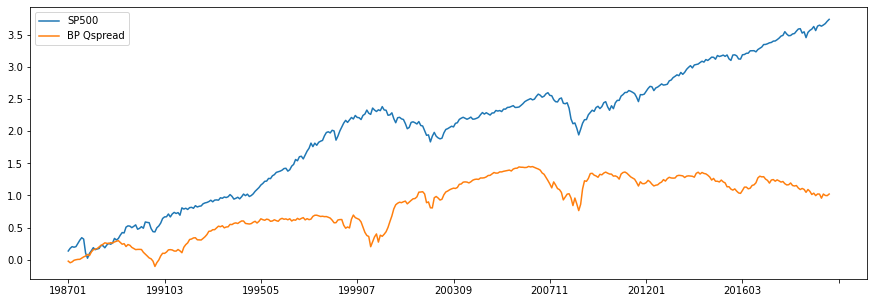

In [32]:
# Plot cumulative returns for BP Qspread and SP500 over 198701-201912
plt.rcParams['figure.figsize'] = [15,5]
SP500_cum = SP500['ret_sp500'].loc["198701":"201912"].cumsum()
BP_cum = Qspread_df['BP'].loc["198701":"201912"].cumsum()
pd.concat([SP500_cum, BP_cum], axis=1,keys=['SP500', 'BP Qspread']).plot()

In [33]:
SP500_cum
BP_cum

198701   -0.022855
198702   -0.047473
198703   -0.034200
198704   -0.009112
198705   -0.000972
            ...   
201908    0.958215
201909    1.022259
201910    1.000092
201911    0.997566
201912    1.022374
Name: BP, Length: 396, dtype: float64

## Question 2

In [34]:
# Calculate correlation of replicated factors and the corresponding Capital IQ benchmarks 
corr = []
for i in col_names:
    benchmark = CapitalIQ[i]
    portfolio = Qspread_df.loc["198701":"201912",i]
    corr_df = pd.concat([portfolio, benchmark], axis=1)
    corr_df.dropna(inplace=True)
    corr.append(stats.pearsonr(corr_df.iloc[:,0],corr_df.iloc[:,1])[0])
    
# Print the correlation table
corr_table = pd.DataFrame(index=col_names)
corr_table['Correlation'] = corr
corr_table

,Correlation
HL1M,0.991954
LTGC,0.913448
MOM,0.926230
BP,0.988694
Beta,0.997656
LogMktCap,0.993669
AnnVol12M,0.965351


## Question 3

In [35]:
# Calculate turnover rate of SP500 in the sample period
turnover_sp500 = []
prev=[]
for i in sp500_ind.transpose().columns:
    firm = pd.DataFrame(sp500_ind.transpose()[i]).dropna().index.tolist()
    if len(prev) != 0:
            turnover_num = len(firm) + len(prev) - 2*len(set(firm).intersection(prev))         
            turnover_sp500.append(turnover_num /len(prev))
    # Reset previous month S&P 500 firms
    prev = firm

In [36]:
avg_turnover_sp500 = np.mean(turnover_sp500)
AvgTurnover_list.append(avg_turnover_sp500)

In [37]:
Qspread_df['ret_sp500'] = data['ret_sp500'][~data['ret_sp500'].index.duplicated(keep='first')]
Qspread_df['rf'] = data['rf'][~data['rf'].index.duplicated(keep='first')]

In [38]:
names = ['HL1M', 'LTGC', 'MOM', 'BP', 'Beta', 'LogMktCap', 'AnnVol12M','ret_sp500']
stats_index = ['Mean (%)','STD (%)','Sharpe Ratio','Skewness','Kurtosis','Max (%)','Min (%)','Average Turnover (%)','ACF 1','ACF 12','ACF 24']

In [39]:
Stats = pd.DataFrame(columns = names, index=stats_index)

In [40]:
# Calculate key statistics
Stats.loc['Mean (%)',:]=(Qspread_df.mean(axis=0)[:-1]*100).tolist()
Stats.loc['STD (%)',:]=(Qspread_df.std(axis=0)[:-1]*100).tolist()
Stats.loc['Skewness',:]=Qspread_df.skew(axis=0)[:-1].tolist()
Stats.loc['Kurtosis',:]=(Qspread_df.kurt(axis=0)[:-1]+3).tolist()#normal distribution has kurtosis of 3
Stats.loc['Max (%)',:]=(Qspread_df.max(axis=0)[:-1]*100).tolist()
Stats.loc['Min (%)',:]=(Qspread_df.min(axis=0)[:-1]*100).tolist()
Stats.loc['Average Turnover (%)',:]=(np.array(AvgTurnover_list)*100).tolist()

In [41]:
# Calculate ACFs
ACF1 = []
ACF12 = []
ACF24 = []
for i in Qspread_df.columns[:-1]:
    ACF1.append(sm.tsa.acf(Qspread_df[i].dropna(), nlags=1)[-1])
    ACF12.append(sm.tsa.acf(Qspread_df[i].dropna(), nlags=12)[-1])
    ACF24.append(sm.tsa.acf(Qspread_df[i].dropna(), nlags=24)[-1])

In [42]:
# Calculate Sharpe Ratio 
# risk_prem = pd.DataFrame(columns = names, index=)
sharpe_ratio = [(Qspread_df[i] - Qspread_df['rf']).mean(axis=0)/(Stats.loc['STD (%)',i]/100) for i in Qspread_df.columns[:-1]]

In [43]:
Stats.loc['ACF 1',:] = ACF1
Stats.loc['ACF 12',:] = ACF12
Stats.loc['ACF 24',:] = ACF24
Stats.loc['Sharpe Ratio'] = sharpe_ratio

In [44]:
Stats

,HL1M,LTGC,MOM,BP,Beta,LogMktCap,AnnVol12M,ret_sp500
Mean (%),0.973795,0.031824,0.411656,0.489502,0.161732,0.543627,0.144126,0.958023
STD (%),3.429298,4.435405,4.979876,4.288084,5.563631,4.246464,5.167569,4.333093
Sharpe Ratio,0.173562,-0.056006,0.007174,0.025863,-0.038092,0.091771,-0.044857,0.133721
Skewness,1.355318,0.20121,-1.172745,1.145487,0.69833,1.428003,0.800329,-0.451653
Kurtosis,9.830007,7.501293,11.086118,10.232411,7.680032,10.289839,9.007543,4.956535
Max (%),23.206698,23.544982,20.957683,29.175452,33.456449,27.116879,33.705856,16.8113
Min (%),-10.817883,-19.802665,-37.554607,-15.883025,-22.351811,-10.270637,-22.87826,-21.5795
Average Turnover (%),162.339032,22.968008,49.109685,20.007924,13.937437,9.071219,23.900496,0.769508
ACF 1,-0.078703,0.010267,0.07361,0.10981,0.068014,0.187278,0.072082,0.026757
ACF 12,0.043732,-0.038298,0.03704,0.130899,0.037867,0.111284,0.01894,0.046696


In [45]:
# Correlation Matrix
Qspread_df.loc['198701':'201912'].corr()

,HL1M,LTGC,MOM,BP,Beta,LogMktCap,AnnVol12M,ret_sp500,rf
HL1M,1.000000,0.243377,-0.460057,0.418047,0.474466,0.443749,0.493526,0.319034,-0.004519
LTGC,0.243377,1.000000,0.144562,-0.335474,0.649510,-0.049765,0.644435,0.421945,0.009597
MOM,-0.460057,0.144562,1.000000,-0.718582,-0.331937,-0.685363,-0.358273,-0.172943,0.042781
BP,0.418047,-0.335474,-0.718582,1.000000,0.298977,0.797978,0.309954,0.214717,-0.009479
Beta,0.474466,0.649510,-0.331937,0.298977,1.000000,0.510775,0.927672,0.642664,-0.027908
LogMktCap,0.443749,-0.049765,-0.685363,0.797978,0.510775,1.000000,0.527455,0.374390,-0.053912
AnnVol12M,0.493526,0.644435,-0.358273,0.309954,0.927672,0.527455,1.000000,0.602834,-0.048882
ret_sp500,0.319034,0.421945,-0.172943,0.214717,0.642664,0.374390,0.602834,1.000000,0.026626
rf,-0.004519,0.009597,0.042781,-0.009479,-0.027908,-0.053912,-0.048882,0.026626,1.000000


## Question 4

In [46]:
tnames = ['Average Spread (%)','t statistics', 'p-value']
test = pd.DataFrame(columns = tnames, index=col_names)

In [47]:
# Perform t test on each portfolio and calculate test statistics and p value
tstats= []
pvalue = []
for i in Qspread_df.columns[:-1]:
    if i == 'ret_sp500': break
    tstats.append(stats.ttest_1samp(Qspread_df[i].dropna(), popmean=0)[0])
    pvalue.append(stats.ttest_1samp(Qspread_df[i].dropna(), popmean=0)[1])

In [48]:
test['t statistics'] = np.round(tstats, 3)
test['p-value'] = np.round(pvalue, 3)
test['Average Spread (%)'] = np.round(((Qspread_df.mean(axis=0)*100).tolist())[:-2], 3)

In [49]:
test

,Average Spread (%),t statistics,p-value
HL1M,0.974,6.950,0.000
LTGC,0.032,0.148,0.882
MOM,0.412,2.003,0.046
BP,0.490,2.794,0.005
Beta,0.162,0.683,0.495
LogMktCap,0.544,2.064,0.040
AnnVol12M,0.144,0.676,0.499
